In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [3]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "../data_msg_type/"
trainX_path = dataset_path + "semantic_train_x.txt"
trainY_path = dataset_path + "semantic_train_y.txt"
testX_path = dataset_path + "semantic_test_x.txt"
testY_path = dataset_path + "semantic_test_y.txt"


train_x = load_X(trainX_path)
train_y = load_y(trainY_path)
test_x = load_X(testX_path)
test_y = load_y(testY_path)

train_x = train_x.reshape(len(train_x), 10, 14, 1)
test_x = test_x.reshape(len(test_x), 10, 14, 1)

'''
# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
'''

print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Dataset separated.

((80000, 10, 14, 1), (80000, 14), (20000, 10, 14, 1), (20000, 14))


# define parameters

In [5]:
learning_rate = 0.0001
training_iters = 16000000
batch_size = 1000
display_step = 20000

# Network Parameters
input_height = 10
input_width = 14
num_channels = 1
n_classes = 14
dropout = 0.75 # Dropout, probability to keep units

# network config

In [6]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 10, 14, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)
    
    # Convolution Layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Max Pooling (down-sampling)
    conv3 = maxpool2d(conv3, k=2)
    print(conv3.shape)

    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    print(fc1.shape)
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    print(fc2.shape)
    fc3 = tf.add(tf.matmul(fc2, weights['wd3']), biases['bd3'])
    fc3 = tf.nn.relu(fc3)
    fc3 = tf.nn.dropout(fc3, dropout)
    print(fc3.shape)

    # Output, class prediction
    fc4 = tf.add(tf.matmul(fc3, weights['out']), biases['out'])
    print(fc4.shape)
    return fc4

# Store layers weight & bias
weights = {
    # 3x4 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([3, 4, 1, 32])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([3, 4, 32, 64])),
    # 3x4 conv, 64 inputs, 64 outputs
    'wc3': tf.Variable(tf.random_normal([3, 4, 64, 64])),
    # fully connected, 2*2*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([2*2*64, 1024])),
    # fully connected, 1024 inputs, 512 outputs
    'wd2': tf.Variable(tf.random_normal([1024, 512])),
    # fully connected, 512 inputs, 1024 outputs
    'wd3': tf.Variable(tf.random_normal([512, 1024])),
    # 1024 inputs, 14outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bc3': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'bd2': tf.Variable(tf.random_normal([512])),
    'bd3': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# build model

In [7]:
x = tf.placeholder(tf.float32, [None,input_height,input_width,num_channels])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

(?, 5, 7, 32)
(?, 3, 4, 64)
(?, 2, 2, 64)
(?, 1024)
(?, 512)
(?, 1024)
(?, 14)


# train and test

In [8]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s


test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


init = tf.global_variables_initializer()
with tf.Session(config=sess_config) as sess:
    sess.run(init)
    
    step = 1
    # Keep training until reach max iterations
    while step * batch_size <= training_iters:
        batch_xs = extract_batch_size(train_x, step, batch_size)
        batch_ys = extract_batch_size(train_y, step, batch_size)

        # Fit training using batch data
        _, loss, acc = sess.run([optimizer, cost, accuracy],
                       feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})

        train_losses.append(loss)
        train_accuracies.append(acc)  
        
        
        batch_xt = extract_batch_size(test_x, step, batch_size)
        batch_yt = extract_batch_size(test_y, step, batch_size)
    
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_predict, test_loss, test_acc = sess.run([pred, cost, accuracy], 
                                            feed_dict={x: batch_xt, y: batch_yt, keep_prob: 1.})
        
        test_predictions.append(np.argmax(test_predict, axis=1))
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_step == 0) or (step == 1) \
            or (step * batch_size > training_iters):

            print("Training epochs #" + str(step*batch_size) + \
                  ": Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))
        
            print("Performance on test set: " + "Training epochs #" + str(step*batch_size) +\
                  ", Batch Loss = {}".format(test_loss) + ", Accuracy = {}".format(test_acc))
        step += 1

    print("Optimization Finished!")

Training epochs #1000: Batch Loss = 93926592.000000, Accuracy = 0.0419999994338
Performance on test set: Training epochs #1000, Batch Loss = 30659510.0, Accuracy = 0.0
Training epochs #20000: Batch Loss = 58458176.000000, Accuracy = 0.0720000043511
Performance on test set: Training epochs #20000, Batch Loss = 17952266.0, Accuracy = 0.01600000076
Training epochs #40000: Batch Loss = 25507248.000000, Accuracy = 0.244000017643
Performance on test set: Training epochs #40000, Batch Loss = 4217987.5, Accuracy = 0.805000007153
Training epochs #60000: Batch Loss = 14771054.000000, Accuracy = 0.511999964714
Performance on test set: Training epochs #60000, Batch Loss = 7259427.5, Accuracy = 0.805000066757
Training epochs #80000: Batch Loss = 12489653.000000, Accuracy = 0.64099997282
Performance on test set: Training epochs #80000, Batch Loss = 8160257.5, Accuracy = 0.804999947548
Training epochs #100000: Batch Loss = 49975072.000000, Accuracy = 0.0790000036359
Performance on test set: Training 

Training epochs #920000: Batch Loss = 2232797.500000, Accuracy = 0.681999981403
Performance on test set: Training epochs #920000, Batch Loss = 362783.9375, Accuracy = 0.946000039577
Training epochs #940000: Batch Loss = 1721185.750000, Accuracy = 0.78100001812
Performance on test set: Training epochs #940000, Batch Loss = 545473.5625, Accuracy = 0.943000018597
Training epochs #960000: Batch Loss = 1272922.000000, Accuracy = 0.824000000954
Performance on test set: Training epochs #960000, Batch Loss = 668552.9375, Accuracy = 0.943000078201
Training epochs #980000: Batch Loss = 11276376.000000, Accuracy = 0.234000012279
Performance on test set: Training epochs #980000, Batch Loss = 357905.03125, Accuracy = 0.945999979973
Training epochs #1000000: Batch Loss = 2103459.250000, Accuracy = 0.68599998951
Performance on test set: Training epochs #1000000, Batch Loss = 295643.6875, Accuracy = 0.946000099182
Training epochs #1020000: Batch Loss = 1753976.125000, Accuracy = 0.761000037193
Perform

Training epochs #1820000: Batch Loss = 731430.500000, Accuracy = 0.846000015736
Performance on test set: Training epochs #1820000, Batch Loss = 124938.882812, Accuracy = 0.964000046253
Training epochs #1840000: Batch Loss = 405697.125000, Accuracy = 0.884999990463
Performance on test set: Training epochs #1840000, Batch Loss = 153483.734375, Accuracy = 0.963999986649
Training epochs #1860000: Batch Loss = 4536566.000000, Accuracy = 0.33599999547
Performance on test set: Training epochs #1860000, Batch Loss = 82996.921875, Accuracy = 0.963999986649
Training epochs #1880000: Batch Loss = 761104.000000, Accuracy = 0.787999987602
Performance on test set: Training epochs #1880000, Batch Loss = 73157.0625, Accuracy = 0.967999994755
Training epochs #1900000: Batch Loss = 651235.375000, Accuracy = 0.846999943256
Performance on test set: Training epochs #1900000, Batch Loss = 114553.085938, Accuracy = 0.963999986649
Training epochs #1920000: Batch Loss = 469663.593750, Accuracy = 0.868000030518

Training epochs #2720000: Batch Loss = 205402.156250, Accuracy = 0.912000060081
Performance on test set: Training epochs #2720000, Batch Loss = 66031.78125, Accuracy = 0.963999986649
Training epochs #2740000: Batch Loss = 2369300.250000, Accuracy = 0.388999998569
Performance on test set: Training epochs #2740000, Batch Loss = 28241.4824219, Accuracy = 0.985000014305
Training epochs #2760000: Batch Loss = 257789.812500, Accuracy = 0.870999932289
Performance on test set: Training epochs #2760000, Batch Loss = 27705.5117188, Accuracy = 0.986000061035
Training epochs #2780000: Batch Loss = 310922.093750, Accuracy = 0.882000088692
Performance on test set: Training epochs #2780000, Batch Loss = 48208.09375, Accuracy = 0.963999986649
Training epochs #2800000: Batch Loss = 128390.804688, Accuracy = 0.924000024796
Performance on test set: Training epochs #2800000, Batch Loss = 60862.9570312, Accuracy = 0.963999986649
Training epochs #2820000: Batch Loss = 2362659.750000, Accuracy = 0.3939999938

Training epochs #3620000: Batch Loss = 1415907.875000, Accuracy = 0.481000006199
Performance on test set: Training epochs #3620000, Batch Loss = 17911.5253906, Accuracy = 0.994000077248
Training epochs #3640000: Batch Loss = 150525.625000, Accuracy = 0.909999966621
Performance on test set: Training epochs #3640000, Batch Loss = 18495.2285156, Accuracy = 0.994000077248
Training epochs #3660000: Batch Loss = 139033.703125, Accuracy = 0.910000026226
Performance on test set: Training epochs #3660000, Batch Loss = 17092.6992188, Accuracy = 0.993000030518
Training epochs #3680000: Batch Loss = 73112.328125, Accuracy = 0.944000065327
Performance on test set: Training epochs #3680000, Batch Loss = 18901.5625, Accuracy = 0.98500007391
Training epochs #3700000: Batch Loss = 1375760.125000, Accuracy = 0.487000018358
Performance on test set: Training epochs #3700000, Batch Loss = 16850.7246094, Accuracy = 0.994000077248
Training epochs #3720000: Batch Loss = 159519.625000, Accuracy = 0.89200001955

Training epochs #4520000: Batch Loss = 92412.750000, Accuracy = 0.917000055313
Performance on test set: Training epochs #4520000, Batch Loss = 10738.7890625, Accuracy = 0.994000077248
Training epochs #4540000: Batch Loss = 64278.449219, Accuracy = 0.947000086308
Performance on test set: Training epochs #4540000, Batch Loss = 9910.18847656, Accuracy = 0.994000077248
Training epochs #4560000: Batch Loss = 40398.847656, Accuracy = 0.969000101089
Performance on test set: Training epochs #4560000, Batch Loss = 9243.20117188, Accuracy = 0.993000030518
Training epochs #4580000: Batch Loss = 761795.812500, Accuracy = 0.565999984741
Performance on test set: Training epochs #4580000, Batch Loss = 9692.03417969, Accuracy = 0.994000077248
Training epochs #4600000: Batch Loss = 120165.765625, Accuracy = 0.898999989033
Performance on test set: Training epochs #4600000, Batch Loss = 10450.9550781, Accuracy = 0.994000077248
Training epochs #4620000: Batch Loss = 99192.851562, Accuracy = 0.929000079632

Training epochs #5420000: Batch Loss = 54731.375000, Accuracy = 0.959000110626
Performance on test set: Training epochs #5420000, Batch Loss = 4867.67871094, Accuracy = 0.994000077248
Training epochs #5440000: Batch Loss = 23254.390625, Accuracy = 0.974000036716
Performance on test set: Training epochs #5440000, Batch Loss = 4559.6171875, Accuracy = 0.994000077248
Training epochs #5460000: Batch Loss = 495196.281250, Accuracy = 0.625
Performance on test set: Training epochs #5460000, Batch Loss = 4709.8984375, Accuracy = 0.994000077248
Training epochs #5480000: Batch Loss = 43389.621094, Accuracy = 0.938000023365
Performance on test set: Training epochs #5480000, Batch Loss = 4882.89306641, Accuracy = 0.994000077248
Training epochs #5500000: Batch Loss = 49890.035156, Accuracy = 0.945000052452
Performance on test set: Training epochs #5500000, Batch Loss = 4208.66357422, Accuracy = 0.994000077248
Training epochs #5520000: Batch Loss = 20402.437500, Accuracy = 0.972000062466
Performance

Training epochs #6320000: Batch Loss = 17004.685547, Accuracy = 0.96899998188
Performance on test set: Training epochs #6320000, Batch Loss = 1261.06213379, Accuracy = 0.994000077248
Training epochs #6340000: Batch Loss = 335081.906250, Accuracy = 0.694999992847
Performance on test set: Training epochs #6340000, Batch Loss = 2163.37548828, Accuracy = 0.994000077248
Training epochs #6360000: Batch Loss = 29728.355469, Accuracy = 0.952000021935
Performance on test set: Training epochs #6360000, Batch Loss = 2419.9987793, Accuracy = 0.994000077248
Training epochs #6380000: Batch Loss = 14803.238281, Accuracy = 0.969000041485
Performance on test set: Training epochs #6380000, Batch Loss = 1898.18518066, Accuracy = 0.994000077248
Training epochs #6400000: Batch Loss = 8027.809570, Accuracy = 0.981000065804
Performance on test set: Training epochs #6400000, Batch Loss = 1594.74353027, Accuracy = 0.994000077248
Training epochs #6420000: Batch Loss = 244138.171875, Accuracy = 0.703999996185
Pe

Training epochs #7220000: Batch Loss = 156097.921875, Accuracy = 0.739000022411
Performance on test set: Training epochs #7220000, Batch Loss = 51.795753479, Accuracy = 0.994000077248
Training epochs #7240000: Batch Loss = 11886.024414, Accuracy = 0.964000046253
Performance on test set: Training epochs #7240000, Batch Loss = 59.6591262817, Accuracy = 0.994000077248
Training epochs #7260000: Batch Loss = 18348.208984, Accuracy = 0.972000002861
Performance on test set: Training epochs #7260000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7280000: Batch Loss = 5428.773438, Accuracy = 0.980999946594
Performance on test set: Training epochs #7280000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7300000: Batch Loss = 179041.812500, Accuracy = 0.743000030518
Performance on test set: Training epochs #7300000, Batch Loss = 62.35912323, Accuracy = 0.994000077248
Training epochs #7320000: Batch Loss = 9798.707031, Accuracy = 0.973000109196
Performance on test set: T

Training epochs #8180000: Batch Loss = 117202.648438, Accuracy = 0.789999961853
Performance on test set: Training epochs #8180000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8200000: Batch Loss = 3867.003174, Accuracy = 0.981000006199
Performance on test set: Training epochs #8200000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8220000: Batch Loss = 7679.141602, Accuracy = 0.980999946594
Performance on test set: Training epochs #8220000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8240000: Batch Loss = 3364.187988, Accuracy = 0.986999988556
Performance on test set: Training epochs #8240000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8260000: Batch Loss = 108045.312500, Accuracy = 0.781999945641
Performance on test set: Training epochs #8260000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8280000: Batch Loss = 6657.749512, Accuracy = 0.976999998093
Performance on test set: Training epochs #8280000, Batch L

Training epochs #9140000: Batch Loss = 62685.238281, Accuracy = 0.833999991417
Performance on test set: Training epochs #9140000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9160000: Batch Loss = 5584.706055, Accuracy = 0.972999989986
Performance on test set: Training epochs #9160000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9180000: Batch Loss = 8279.658203, Accuracy = 0.98400002718
Performance on test set: Training epochs #9180000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9200000: Batch Loss = 1916.454346, Accuracy = 0.990000009537
Performance on test set: Training epochs #9200000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #9220000: Batch Loss = 66059.710938, Accuracy = 0.833000004292
Performance on test set: Training epochs #9220000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9240000: Batch Loss = 4557.939941, Accuracy = 0.985000014305
Performance on test set: Training epochs #9240000, Batch Loss = 0.0, Ac

Training epochs #10100000: Batch Loss = 33284.128906, Accuracy = 0.886000037193
Performance on test set: Training epochs #10100000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10120000: Batch Loss = 2842.544189, Accuracy = 0.98400002718
Performance on test set: Training epochs #10120000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10140000: Batch Loss = 2636.258545, Accuracy = 0.990999937057
Performance on test set: Training epochs #10140000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10160000: Batch Loss = 1701.248901, Accuracy = 0.995000064373
Performance on test set: Training epochs #10160000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10180000: Batch Loss = 35776.000000, Accuracy = 0.870999991894
Performance on test set: Training epochs #10180000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10200000: Batch Loss = 1971.124146, Accuracy = 0.988999962807
Performance on test set: Training epochs #10200000

Training epochs #11060000: Batch Loss = 25969.326172, Accuracy = 0.874000072479
Performance on test set: Training epochs #11060000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11080000: Batch Loss = 1700.202759, Accuracy = 0.991999983788
Performance on test set: Training epochs #11080000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11100000: Batch Loss = 2295.234375, Accuracy = 0.981999993324
Performance on test set: Training epochs #11100000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11120000: Batch Loss = 1107.900635, Accuracy = 0.989000022411
Performance on test set: Training epochs #11120000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11140000: Batch Loss = 15956.402344, Accuracy = 0.902999997139
Performance on test set: Training epochs #11140000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11160000: Batch Loss = 1371.305542, Accuracy = 0.989000022411
Performance on test set: Training epochs #1116000

Training epochs #12020000: Batch Loss = 18784.773438, Accuracy = 0.914000034332
Performance on test set: Training epochs #12020000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12040000: Batch Loss = 851.755371, Accuracy = 0.992000102997
Performance on test set: Training epochs #12040000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12060000: Batch Loss = 1159.026001, Accuracy = 0.988999962807
Performance on test set: Training epochs #12060000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12080000: Batch Loss = 389.003967, Accuracy = 0.994000017643
Performance on test set: Training epochs #12080000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12100000: Batch Loss = 14590.236328, Accuracy = 0.913999974728
Performance on test set: Training epochs #12100000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12120000: Batch Loss = 1005.119141, Accuracy = 0.989000082016
Performance on test set: Training epochs #12120000,

Training epochs #12980000: Batch Loss = 12249.959961, Accuracy = 0.920000076294
Performance on test set: Training epochs #12980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13000000: Batch Loss = 114.983032, Accuracy = 0.992999970913
Performance on test set: Training epochs #13000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13020000: Batch Loss = 530.168457, Accuracy = 0.995000123978
Performance on test set: Training epochs #13020000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13040000: Batch Loss = 502.690399, Accuracy = 0.993000030518
Performance on test set: Training epochs #13040000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13060000: Batch Loss = 8008.346680, Accuracy = 0.919000029564
Performance on test set: Training epochs #13060000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13080000: Batch Loss = 393.956299, Accuracy = 0.993000030518
Performance on test set: Training epochs #13080000, Ba

Training epochs #13940000: Batch Loss = 8982.658203, Accuracy = 0.936000049114
Performance on test set: Training epochs #13940000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13960000: Batch Loss = 481.415131, Accuracy = 0.987999916077
Performance on test set: Training epochs #13960000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13980000: Batch Loss = 267.435760, Accuracy = 0.996000111103
Performance on test set: Training epochs #13980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14000000: Batch Loss = 227.050446, Accuracy = 0.999000072479
Performance on test set: Training epochs #14000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14020000: Batch Loss = 5306.717773, Accuracy = 0.939999997616
Performance on test set: Training epochs #14020000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14040000: Batch Loss = 400.870850, Accuracy = 0.996000051498
Performance on test set: Training epochs #14040000, Bat

Training epochs #14900000: Batch Loss = 4532.608398, Accuracy = 0.953000068665
Performance on test set: Training epochs #14900000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14920000: Batch Loss = 400.062622, Accuracy = 0.993999958038
Performance on test set: Training epochs #14920000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14940000: Batch Loss = 373.383606, Accuracy = 0.994000077248
Performance on test set: Training epochs #14940000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14960000: Batch Loss = 36.260025, Accuracy = 0.999000072479
Performance on test set: Training epochs #14960000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14980000: Batch Loss = 6343.618164, Accuracy = 0.954000115395
Performance on test set: Training epochs #14980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15000000: Batch Loss = 170.040146, Accuracy = 0.997000038624
Performance on test set: Training epochs #15000000, Batc

Training epochs #15860000: Batch Loss = 3720.863525, Accuracy = 0.935000002384
Performance on test set: Training epochs #15860000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15880000: Batch Loss = 414.659790, Accuracy = 0.994000017643
Performance on test set: Training epochs #15880000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15900000: Batch Loss = 648.309937, Accuracy = 0.994000077248
Performance on test set: Training epochs #15900000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15920000: Batch Loss = 183.975723, Accuracy = 0.995000004768
Performance on test set: Training epochs #15920000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15940000: Batch Loss = 5785.130371, Accuracy = 0.952000081539
Performance on test set: Training epochs #15940000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #15960000: Batch Loss = 149.817612, Accuracy = 0.994000017643
Performance on test set: Training epochs #15960000, Batch Loss = 

# performance visualization

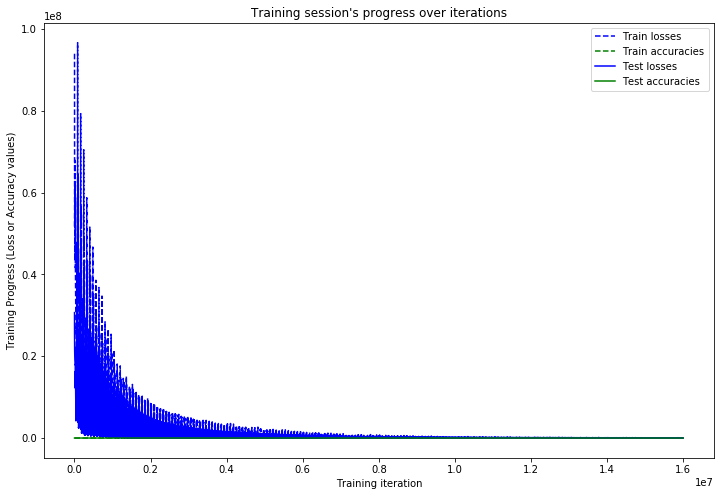

In [9]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)
width = 12
height = 8
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, 
                   (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(batch_size, 
                  len(test_losses)*batch_size, batch_size)), training_iters)
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

Best Testing Accuracy: 100.000011921%

Precision: 97.291380694%
Recall: 97.235%
f1_score: 97.2012542389%

Confusion Matrix:
[[    7    11     0     0     0     0     0     0     0     0     0     0
      0]
 [   15   772     0     0    37    18    23    15     7     0     0    24
      0]
 [    0     0   213     0     0     0     0     0     0     0     0     0
      0]
 [    0     2     0     0     0     0     0     0     0     0     0     0
      0]
 [    0    35     0     0  2799    10     1    12     0     0     0    34
      0]
 [   14    42     0     0     0   284     0     5     0     0     0     3
      0]
 [    0     9     0     0     0     0 14486     0     0     0     0     0
      0]
 [    0    47     0     0    35    59     6   369     9     0     0    10
      0]
 [    0     0     0     0     0     0     0     0   132     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     2     2     0     0
      0]
 [    0     0     0     0     0     0     0   

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


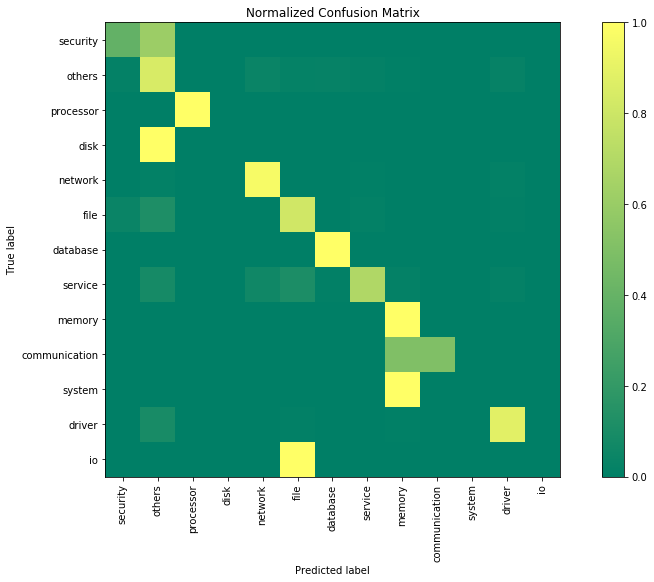

In [10]:
# Results
predictions = []
length = len(test_predictions)-20
for i in range(20):
    predictions.extend(test_predictions[length+i])

true_y = np.argmax(test_y, axis=1)

print("Best Testing Accuracy: {}%".format(100*max(test_accuracies)))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    true_y, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(true_y, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(true_y, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(true_y, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    true_y, predictions, target_names = list(labels.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)